In [1]:
import h5py
import numpy as np
import pandas as pd
from scipy.sparse import csc_matrix,csr_matrix, issparse

In [2]:
with h5py.File('1M_neurons_neuron20k.h5', 'r') as f:
    # Access the group
    group = f['mm10']
    
    # Print what's inside the mm10 group
    print("Contents of mm10 group:")
    print(list(group.keys()))
    
    # Check the type of each item
    for key in group.keys():
        item = group[key]
        if isinstance(item, h5py.Dataset):
            print(f"Dataset: {key}, shape: {item.shape}, dtype: {item.dtype}")
        elif isinstance(item, h5py.Group):
            print(f"Group: {key}")


Contents of mm10 group:
['barcodes', 'data', 'gene_names', 'genes', 'indices', 'indptr', 'shape']
Dataset: barcodes, shape: (20000,), dtype: |S20
Dataset: data, shape: (40210699,), dtype: int32
Dataset: gene_names, shape: (27998,), dtype: |S14
Dataset: genes, shape: (27998,), dtype: |S18
Dataset: indices, shape: (40210699,), dtype: int64
Dataset: indptr, shape: (20001,), dtype: int64
Dataset: shape, shape: (2,), dtype: int32


In [3]:
with h5py.File('1M_neurons_neuron20k.h5', 'r') as f:
    def explore_structure(name, obj):
        if isinstance(obj, h5py.Dataset):
            print(f"Dataset: {name}, shape: {obj.shape}, dtype: {obj.dtype}")
        elif isinstance(obj, h5py.Group):
            print(f"Group: {name}")
    
    f.visititems(explore_structure)


Group: mm10
Dataset: mm10/barcodes, shape: (20000,), dtype: |S20
Dataset: mm10/data, shape: (40210699,), dtype: int32
Dataset: mm10/gene_names, shape: (27998,), dtype: |S14
Dataset: mm10/genes, shape: (27998,), dtype: |S18
Dataset: mm10/indices, shape: (40210699,), dtype: int64
Dataset: mm10/indptr, shape: (20001,), dtype: int64
Dataset: mm10/shape, shape: (2,), dtype: int32


In [4]:
# Load the data
with h5py.File('1M_neurons_neuron20k.h5', 'r') as f:
    data = f['mm10/data'][()]
    indices = f['mm10/indices'][()]
    indptr = f['mm10/indptr'][()]
    shape = f['mm10/shape'][()]
    gene_names = f['mm10/gene_names'][()].astype(str)
    
# Already loaded - Raw count matrix (cells × genes)

X = csr_matrix((data, indices, indptr), shape=(shape[1], shape[0]))
print(f"Shape (cells x genes): {X.shape}")  # Should be (20000, 27998)

print(f"Raw data shape: {X.shape}")
print(f"Total counts range: {X.sum(axis=1).min():.0f} - {X.sum(axis=1).max():.0f}")

Shape (cells x genes): (20000, 27998)
Raw data shape: (20000, 27998)
Total counts range: 1210 - 70710


In [5]:
# Step 2: Log-normalization
# Normalize each cell to have the same total count (typically 10,000)
target_sum = 1e4
cell_sums = np.array(X.sum(axis=1)).flatten()
X_norm = X.multiply(target_sum / cell_sums[:, np.newaxis])

# Log transform: log(x + 1)
X_norm = X_norm.tocsr()
X_norm.data = np.log1p(X_norm.data)
print(f"After log-normalization: {X_norm.shape}")

After log-normalization: (20000, 27998)


In [6]:
# Step 3: Highly variable gene selection
# Convert to dense for gene statistics (or use sparse operations)
X_dense = X_norm.toarray()


In [7]:

# Calculate mean and variance for each gene
gene_mean = X_dense.mean(axis=0)
gene_var = X_dense.var(axis=0)

# Calculate normalized dispersion
mean_var_ratio = gene_var / (gene_mean + 1e-12)

# Select top highly variable genes (e.g., 2000)
n_top_genes = 2000
top_genes_idx = np.argsort(mean_var_ratio)[-n_top_genes:]
X_hvg = X_dense[:, top_genes_idx]
selected_genes = gene_names[top_genes_idx]

print(f"After HVG selection: {X_hvg.shape}")
print(f"Selected {n_top_genes} highly variable genes")

After HVG selection: (20000, 2000)
Selected 2000 highly variable genes


In [8]:
np.save("selected_genes.npy", selected_genes)
selected_genes = np.load("selected_genes.npy")

np.save("X_hvg.npy", selected_genes)
selected_genes = np.load("X_hvg.npy")


In [9]:
# Step 4: Scaling (z-score normalization per gene)
gene_mean = X_hvg.mean(axis=0)
gene_std = X_hvg.std(axis=0)
X_scaled = (X_hvg - gene_mean) / (gene_std + 1e-12)

# Clip values to avoid extreme outliers
X_scaled = np.clip(X_scaled, -10, 10)
print(f"After scaling: {X_scaled.shape}")

After scaling: (20000, 2000)


In [10]:
# Install packages (run these in separate cells)
# !pip install umap-learn
# !pip install trimap
# !pip install pacmap
# !pip install phate
# !pip install fa2

In [11]:
import numpy as np
import time
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import trimap
import pacmap
# For PHATE: pip install phate
import phate

In [12]:
# Dictionary to store all embeddings
embeddings = {}
timings = {}

# 1. PCA (2D)
print("\n1. Running PCA...")
start = time.time()
pca = PCA(n_components=2, random_state=42)
embeddings['PCA'] = pca.fit_transform(X_scaled)
timings['PCA'] = time.time() - start
print(f"   PCA completed in {timings['PCA']:.2f}s - Shape: {embeddings['PCA'].shape}")


1. Running PCA...
   PCA completed in 0.45s - Shape: (20000, 2)


In [13]:
# 2. t-SNE
print("\n2. Running t-SNE...")
start = time.time()
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
embeddings['tSNE'] = tsne.fit_transform(X_scaled)
timings['tSNE'] = time.time() - start
print(f"   t-SNE completed in {timings['tSNE']:.2f}s - Shape: {embeddings['tSNE'].shape}")


2. Running t-SNE...
   t-SNE completed in 57.29s - Shape: (20000, 2)


In [14]:
# 3. UMAP
print("\n3. Running UMAP...")
start = time.time()
umap_model = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
embeddings['UMAP'] = umap_model.fit_transform(X_scaled)
timings['UMAP'] = time.time() - start
print(f"   UMAP completed in {timings['UMAP']:.2f}s - Shape: {embeddings['UMAP'].shape}")


3. Running UMAP...


/Users/rkbehera/PySoton/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


   UMAP completed in 31.54s - Shape: (20000, 2)


In [15]:
# 4. TriMap
print("\n4. Running TriMap...")
start = time.time()
trimap_model = trimap.TRIMAP(n_dims=2, n_inliers=10, n_outliers=5, n_random=3)
embeddings['TriMap'] = trimap_model.fit_transform(X_scaled)
timings['TriMap'] = time.time() - start
print(f"   TriMap completed in {timings['TriMap']:.2f}s - Shape: {embeddings['TriMap'].shape}")


4. Running TriMap...
   TriMap completed in 6.67s - Shape: (20000, 2)


In [16]:
# 5. PaCMAP
print("\n5. Running PaCMAP...")
start = time.time()
pacmap_model = pacmap.PaCMAP(n_components=2, n_neighbors=10, MN_ratio=0.5, FP_ratio=2.0)
embeddings['PaCMAP'] = pacmap_model.fit_transform(X_scaled, init="pca")
timings['PaCMAP'] = time.time() - start
print(f"   PaCMAP completed in {timings['PaCMAP']:.2f}s - Shape: {embeddings['PaCMAP'].shape}")


5. Running PaCMAP...
   PaCMAP completed in 4.96s - Shape: (20000, 2)


In [17]:
# Summary
print("\n" + "="*50)
print("SUMMARY: All DR Methods Completed")
print("="*50)
for method, timing in timings.items():
    print(f"{method:12s}: {embeddings[method].shape} in {timing:7.2f}s")

# Save all embeddings
for method, embedding in embeddings.items():
    np.save(f'embedding_{method}.npy', embedding)
    print(f"Saved: embedding_{method}.npy")



SUMMARY: All DR Methods Completed
PCA         : (20000, 2) in    0.45s
tSNE        : (20000, 2) in   57.29s
UMAP        : (20000, 2) in   31.54s
TriMap      : (20000, 2) in    6.67s
PaCMAP      : (20000, 2) in    4.96s
Saved: embedding_PCA.npy
Saved: embedding_tSNE.npy
Saved: embedding_UMAP.npy
Saved: embedding_TriMap.npy
Saved: embedding_PaCMAP.npy


In [18]:
import pandas as pd
import h5py

# Load the neuron20k HDF5 file
h5_file = h5py.File('1M_neurons_neuron20k.h5', 'r')

# Extract barcodes (usually in 'mm10/barcodes' or similar path)
# Check structure first: print(list(h5_file.keys()))
barcodes_20k = h5_file['mm10/barcodes'][:].astype(str)
# or: barcodes_20k = [b.decode('utf-8') for b in h5_file['mm10/barcodes'][:]]

h5_file.close()

# Load full louvain clusters (has barcode in col 0, cluster in col 1)
louvain_full = pd.read_csv('louvain.csv.gz', header=None, 
                           names=['barcode', 'cluster'])

# Filter to keep only the 20k cells
louvain_20k = louvain_full[louvain_full['barcode'].isin(barcodes_20k)]

# Ensure same order as in your data matrix X
barcode_to_cluster = dict(zip(louvain_20k['barcode'], louvain_20k['cluster']))
clusters = [barcode_to_cluster[bc] for bc in barcodes_20k]

# Now X and clusters have matching dimensions
print(len(clusters), X.shape[0])


20000 20000


In [19]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
import pandas as pd

clusters = np.array(clusters)   # add this once after you build clusters

print(f"Labels shape: {clusters.shape}")
print(f"Number of unique cell types: {len(np.unique(clusters))}")


Labels shape: (20000,)
Number of unique cell types: 39


## Evaluation 1: Local Structure Preservation

In [22]:
results_supervised={}
# Evaluate each embedding
for method_name in ['PCA', 'tSNE', 'UMAP', 'TriMap', 'PaCMAP']:
    print(f"\n{'='*60}")
    print(f"Evaluating {method_name}")
    print('='*60)
    
    # Load embedding
    embedding = embeddings[method_name]  # Or: np.load(f'embedding_{method_name}.npy')
    
    # Split data into train/test
    X_train, X_test, y_train, y_test = train_test_split(
        embedding, clusters, test_size=0.3, random_state=42, stratify=clusters
    )
    
    print(f"Train size: {X_train.shape[0]}, Test size: {X_test.shape[0]}")
    
    # 1. k-NN Classifier
    print("\n--- k-NN Classifier ---")
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train, y_train)
    y_pred_knn = knn.predict(X_test)
    
    knn_accuracy = accuracy_score(y_test, y_pred_knn)
    knn_f1_macro = f1_score(y_test, y_pred_knn, average='macro')
    knn_f1_weighted = f1_score(y_test, y_pred_knn, average='weighted')
    
    print(f"Accuracy:        {knn_accuracy:.4f}")
    print(f"F1 (macro):      {knn_f1_macro:.4f}")
    print(f"F1 (weighted):   {knn_f1_weighted:.4f}")
    
    # 2. SVM Classifier
    print("\n--- SVM Classifier ---")
    svm = SVC(kernel='rbf', C=1.0, random_state=42)
    svm.fit(X_train, y_train)
    y_pred_svm = svm.predict(X_test)
    
    svm_accuracy = accuracy_score(y_test, y_pred_svm)
    svm_f1_macro = f1_score(y_test, y_pred_svm, average='macro')
    svm_f1_weighted = f1_score(y_test, y_pred_svm, average='weighted')
    
    print(f"Accuracy:        {svm_accuracy:.4f}")
    print(f"F1 (macro):      {svm_f1_macro:.4f}")
    print(f"F1 (weighted):   {svm_f1_weighted:.4f}")
    
    # Store results
    results_supervised[method_name] = {
        'knn_accuracy': knn_accuracy,
        'knn_f1_macro': knn_f1_macro,
        'knn_f1_weighted': knn_f1_weighted,
        'svm_accuracy': svm_accuracy,
        'svm_f1_macro': svm_f1_macro,
        'svm_f1_weighted': svm_f1_weighted
    }

# Create summary table
print("\n" + "="*80)
print("SUMMARY: Supervised Local Evaluation Results")
print("="*80)

results_df = pd.DataFrame(results_supervised).T
print(results_df.round(4))

# Save results
results_df.to_csv('supervised_local_evaluation.csv')
print("\nResults saved to 'supervised_local_evaluation.csv'")



Evaluating PCA
Train size: 14000, Test size: 6000

--- k-NN Classifier ---
Accuracy:        0.2893
F1 (macro):      0.2117
F1 (weighted):   0.2593

--- SVM Classifier ---
Accuracy:        0.3312
F1 (macro):      0.1976
F1 (weighted):   0.2561

Evaluating tSNE
Train size: 14000, Test size: 6000

--- k-NN Classifier ---
Accuracy:        0.5037
F1 (macro):      0.4580
F1 (weighted):   0.5040

--- SVM Classifier ---
Accuracy:        0.4783
F1 (macro):      0.3617
F1 (weighted):   0.4499

Evaluating UMAP
Train size: 14000, Test size: 6000

--- k-NN Classifier ---
Accuracy:        0.4778
F1 (macro):      0.4357
F1 (weighted):   0.4737

--- SVM Classifier ---
Accuracy:        0.4500
F1 (macro):      0.2995
F1 (weighted):   0.3886

Evaluating TriMap
Train size: 14000, Test size: 6000

--- k-NN Classifier ---
Accuracy:        0.6615
F1 (macro):      0.5638
F1 (weighted):   0.6486

--- SVM Classifier ---
Accuracy:        0.6580
F1 (macro):      0.4857
F1 (weighted):   0.6278

Evaluating PaCMAP


Plot saved to 'supervised_local_evaluation.png'


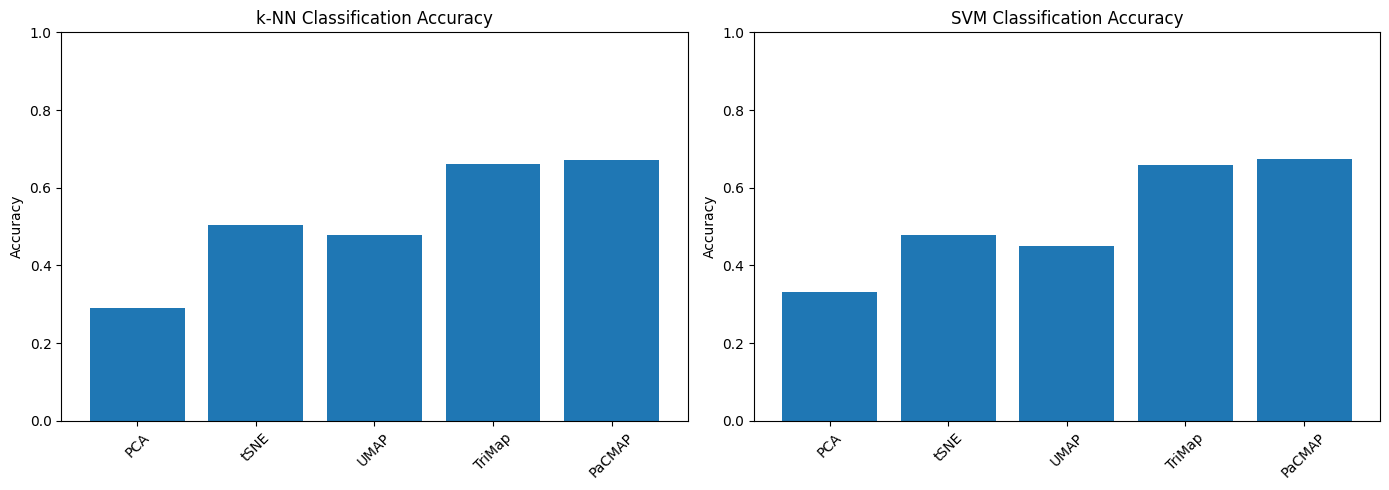

In [23]:
import matplotlib.pyplot as plt

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# k-NN results
axes[0].bar(results_df.index, results_df['knn_accuracy'])
axes[0].set_ylabel('Accuracy')
axes[0].set_title('k-NN Classification Accuracy')
axes[0].set_ylim([0, 1])
axes[0].tick_params(axis='x', rotation=45)

# SVM results
axes[1].bar(results_df.index, results_df['svm_accuracy'])
axes[1].set_ylabel('Accuracy')
axes[1].set_title('SVM Classification Accuracy')
axes[1].set_ylim([0, 1])
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('supervised_local_evaluation.png', dpi=300, bbox_inches='tight')
print("Plot saved to 'supervised_local_evaluation.png'")


## Evaluation 2: Global Structure Preservation

Saved: global_structure_visualization.png


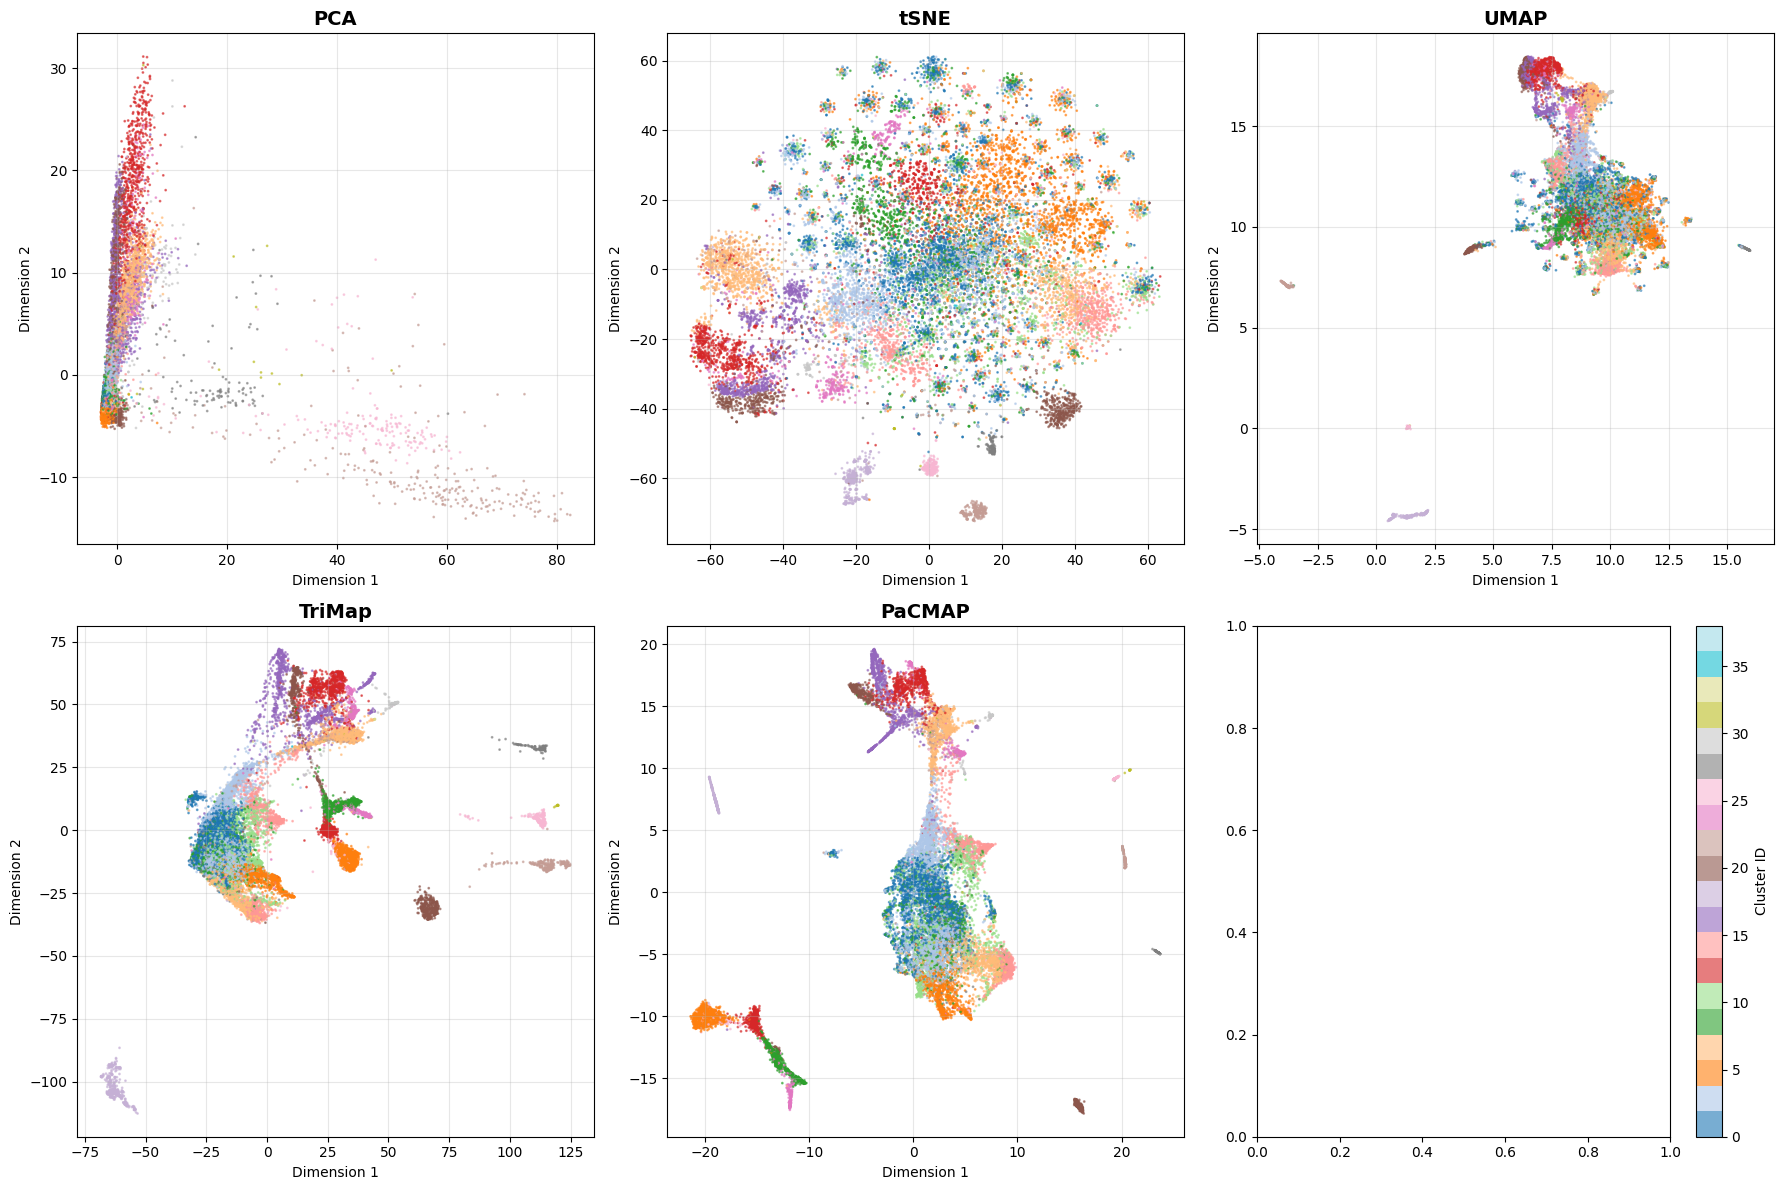

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

# Create visualizations for all methods
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

methods = ['PCA', 'tSNE', 'UMAP', 'TriMap', 'PaCMAP']

# Create a colormap for clusters
n_clusters = len(np.unique(clusters))
colors = plt.cm.tab20(np.linspace(0, 1, n_clusters))

for idx, method_name in enumerate(methods):
    ax = axes[idx]
    embedding = embeddings[method_name]
    
    # Scatter plot colored by cluster labels
    scatter = ax.scatter(
        embedding[:, 0], 
        embedding[:, 1], 
        c=clusters, 
        cmap='tab20',
        s=1,  # Small point size for large datasets
        alpha=0.6,
        rasterized=True  # For better performance with many points
    )
    
    ax.set_title(f'{method_name}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Dimension 1')
    ax.set_ylabel('Dimension 2')
    ax.grid(True, alpha=0.3)

plt.colorbar(scatter, ax=axes[-1], label='Cluster ID')
plt.tight_layout()
plt.savefig('global_structure_visualization.png', dpi=300, bbox_inches='tight')
print("Saved: global_structure_visualization.png")
plt.show()


In [26]:
from scipy.spatial.distance import cdist, pdist, squareform

def random_triplet_accuracy(X_high, X_low, n_triplets=10000, random_state=42):
    """
    Compute random triplet accuracy.
    
    Parameters:
    -----------
    X_high : array, shape (n_samples, n_features_high)
        High-dimensional data
    X_low : array, shape (n_samples, n_features_low)
        Low-dimensional embedding
    n_triplets : int
        Number of random triplets to sample
    
    Returns:
    --------
    accuracy : float
        Proportion of triplets with preserved distance ordering
    """
    np.random.seed(random_state)
    n_samples = X_high.shape[0]
    
    # Randomly sample triplets
    triplets = np.random.randint(0, n_samples, size=(n_triplets, 3))
    
    correct = 0
    
    for i, j, k in triplets:
        # Compute distances in high-dimensional space
        d_ij_high = np.linalg.norm(X_high[i] - X_high[j])
        d_ik_high = np.linalg.norm(X_high[i] - X_high[k])
        
        # Compute distances in low-dimensional space
        d_ij_low = np.linalg.norm(X_low[i] - X_low[j])
        d_ik_low = np.linalg.norm(X_low[i] - X_low[k])
        
        # Check if ordering is preserved
        if (d_ij_high < d_ik_high) == (d_ij_low < d_ik_low):
            correct += 1
    
    accuracy = correct / n_triplets
    return accuracy

# Evaluate all methods
print("\n" + "="*60)
print("Random Triplet Accuracy")
print("="*60)

triplet_results = {}

for method_name in methods:
    print(f"Computing for {method_name}...")
    embedding = embeddings[method_name]
    
    accuracy = random_triplet_accuracy(X_scaled, embedding, n_triplets=10000)
    triplet_results[method_name] = accuracy
    
    print(f"  {method_name}: {accuracy:.4f}")

print("\nHigher scores indicate better global structure preservation")



Random Triplet Accuracy
Computing for PCA...
  PCA: 0.6756
Computing for tSNE...
  tSNE: 0.6045
Computing for UMAP...
  UMAP: 0.6180
Computing for TriMap...
  TriMap: 0.6370
Computing for PaCMAP...
  PaCMAP: 0.6919

Higher scores indicate better global structure preservation


In [27]:
from scipy.stats import spearmanr

def distance_spearman_correlation(X_high, X_low, n_samples=5000, random_state=42):
    """
    Compute Spearman correlation between distances in high and low dimensions.
    
    Parameters:
    -----------
    X_high : array, shape (n_samples, n_features_high)
        High-dimensional data
    X_low : array, shape (n_samples, n_features_low)
        Low-dimensional embedding
    n_samples : int
        Number of points to sample (for computational efficiency)
    
    Returns:
    --------
    correlation : float
        Spearman rank correlation coefficient
    p_value : float
        P-value for the correlation
    """
    np.random.seed(random_state)
    n_total = X_high.shape[0]
    
    # Sample points if dataset is large
    if n_total > n_samples:
        indices = np.random.choice(n_total, n_samples, replace=False)
        X_high_sample = X_high[indices]
        X_low_sample = X_low[indices]
    else:
        X_high_sample = X_high
        X_low_sample = X_low
    
    # Compute pairwise distances
    print(f"  Computing distances for {X_high_sample.shape[0]} samples...")
    dist_high = pdist(X_high_sample, metric='euclidean')
    dist_low = pdist(X_low_sample, metric='euclidean')
    
    # Compute Spearman correlation
    correlation, p_value = spearmanr(dist_high, dist_low)
    
    return correlation, p_value

# Evaluate all methods
print("\n" + "="*60)
print("Distance Spearman Correlation")
print("="*60)

spearman_results = {}

for method_name in methods:
    print(f"Computing for {method_name}...")
    embedding = embeddings[method_name]
    
    correlation, p_value = distance_spearman_correlation(X_scaled, embedding, n_samples=3000)
    spearman_results[method_name] = {
        'correlation': correlation,
        'p_value': p_value
    }
    
    print(f"  {method_name}: ρ = {correlation:.4f} (p < {p_value:.2e})")

print("\nHigher correlation indicates better global distance preservation")



Distance Spearman Correlation
Computing for PCA...
  Computing distances for 3000 samples...
  PCA: ρ = 0.6137 (p < 0.00e+00)
Computing for tSNE...
  Computing distances for 3000 samples...
  tSNE: ρ = 0.3039 (p < 0.00e+00)
Computing for UMAP...
  Computing distances for 3000 samples...
  UMAP: ρ = 0.4079 (p < 0.00e+00)
Computing for TriMap...
  Computing distances for 3000 samples...
  TriMap: ρ = 0.5934 (p < 0.00e+00)
Computing for PaCMAP...
  Computing distances for 3000 samples...
  PaCMAP: ρ = 0.5892 (p < 0.00e+00)

Higher correlation indicates better global distance preservation


In [28]:
from scipy.spatial.distance import cdist

def cluster_centroid_analysis(X_high, X_low, labels):
    """
    Compare cluster centroid relationships in high and low dimensions.
    
    Parameters:
    -----------
    X_high : array, shape (n_samples, n_features_high)
        High-dimensional data
    X_low : array, shape (n_samples, n_features_low)
        Low-dimensional embedding
    labels : array, shape (n_samples,)
        Cluster labels
    
    Returns:
    --------
    results : dict
        Dictionary containing various centroid-based metrics
    """
    unique_labels = np.unique(labels)
    n_clusters = len(unique_labels)
    
    # Compute centroids in both spaces
    centroids_high = np.array([X_high[labels == label].mean(axis=0) for label in unique_labels])
    centroids_low = np.array([X_low[labels == label].mean(axis=0) for label in unique_labels])
    
    # Compute inter-centroid distances
    dist_high = squareform(pdist(centroids_high))
    dist_low = squareform(pdist(centroids_low))
    
    # Compute correlation of inter-centroid distances
    triu_indices = np.triu_indices(n_clusters, k=1)
    dist_high_vec = dist_high[triu_indices]
    dist_low_vec = dist_low[triu_indices]
    
    centroid_corr, _ = spearmanr(dist_high_vec, dist_low_vec)
    
    # Check nearest neighbor preservation for centroids
    nn_preserved = 0
    for i in range(n_clusters):
        # Find nearest neighbor in high-dim (excluding self)
        nn_high = np.argsort(dist_high[i])[1]
        nn_low = np.argsort(dist_low[i])[1]
        
        if nn_high == nn_low:
            nn_preserved += 1
    
    nn_preservation_rate = nn_preserved / n_clusters
    
    return {
        'centroid_correlation': centroid_corr,
        'nn_preservation_rate': nn_preservation_rate,
        'dist_high': dist_high,
        'dist_low': dist_low
    }

# Evaluate all methods
print("\n" + "="*60)
print("Cluster Centroid Analysis")
print("="*60)

centroid_results = {}

for method_name in methods:
    print(f"Analyzing {method_name}...")
    embedding = embeddings[method_name]
    
    results = cluster_centroid_analysis(X_scaled, embedding, clusters)
    centroid_results[method_name] = results
    
    print(f"  Centroid distance correlation: {results['centroid_correlation']:.4f}")
    print(f"  Nearest neighbor preservation:  {results['nn_preservation_rate']:.2%}")



Cluster Centroid Analysis
Analyzing PCA...
  Centroid distance correlation: 0.8296
  Nearest neighbor preservation:  15.38%
Analyzing tSNE...
  Centroid distance correlation: 0.6521
  Nearest neighbor preservation:  28.21%
Analyzing UMAP...
  Centroid distance correlation: 0.7253
  Nearest neighbor preservation:  30.77%
Analyzing TriMap...
  Centroid distance correlation: 0.7227
  Nearest neighbor preservation:  28.21%
Analyzing PaCMAP...
  Centroid distance correlation: 0.5198
  Nearest neighbor preservation:  25.64%


In [29]:
import pandas as pd

# Compile all results
summary_data = []

for method_name in methods:
    summary_data.append({
        'Method': method_name,
        'Triplet Accuracy': triplet_results[method_name],
        'Distance Spearman ρ': spearman_results[method_name]['correlation'],
        'Centroid Correlation': centroid_results[method_name]['centroid_correlation'],
        'NN Preservation': centroid_results[method_name]['nn_preservation_rate']
    })

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.set_index('Method')

print("\n" + "="*80)
print("SUMMARY: Global Structure Preservation Metrics")
print("="*80)
print(summary_df.round(4))

# Save results
summary_df.to_csv('global_structure_evaluation.csv')
print("\nResults saved to 'global_structure_evaluation.csv'")



SUMMARY: Global Structure Preservation Metrics
        Triplet Accuracy  Distance Spearman ρ  Centroid Correlation  \
Method                                                                
PCA               0.6756               0.6137                0.8296   
tSNE              0.6045               0.3039                0.6521   
UMAP              0.6180               0.4079                0.7253   
TriMap            0.6370               0.5934                0.7227   
PaCMAP            0.6919               0.5892                0.5198   

        NN Preservation  
Method                   
PCA              0.1538  
tSNE             0.2821  
UMAP             0.3077  
TriMap           0.2821  
PaCMAP           0.2564  

Results saved to 'global_structure_evaluation.csv'


Saved: global_metrics_comparison.png


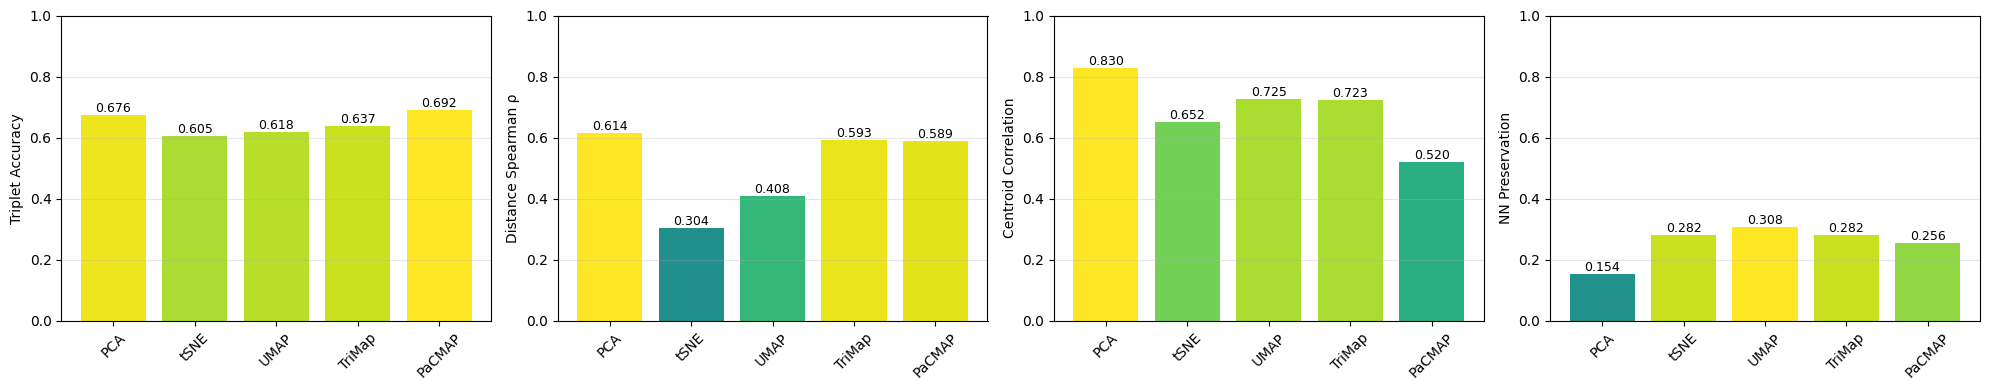

In [30]:
# Create comparison plot
fig, axes = plt.subplots(1, 4, figsize=(20, 4))

metrics = ['Triplet Accuracy', 'Distance Spearman ρ', 'Centroid Correlation', 'NN Preservation']

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    values = summary_df[metric].values
    bars = ax.bar(summary_df.index, values, color=plt.cm.viridis(values / values.max()))
    ax.set_ylabel(metric)
    ax.set_ylim([0, 1])
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bar, val in zip(bars, values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('global_metrics_comparison.png', dpi=300, bbox_inches='tight')
print("Saved: global_metrics_comparison.png")
plt.show()


In [32]:
## Evaluation 3: Sensitivity to Parameter Choices

In [31]:
import numpy as np
import time
from sklearn.manifold import TSNE
import umap.umap_ as umap
import trimap
import pacmap
from scipy.spatial.distance import cdist
from scipy.stats import spearmanr
import pandas as pd
import matplotlib.pyplot as plt

# Parameter ranges for each method
parameter_configs = {
    'tSNE': {
        'param_name': 'perplexity',
        'values': [5, 10, 30, 50, 100, 200]
    },
    'UMAP': {
        'param_name': 'n_neighbors',
        'values': [5, 10, 15, 30, 50, 100, 200]
    },
    'TriMap': {
        'param_name': 'n_inliers',
        'values': [5, 10, 15, 20, 30, 50]
    },
    'PaCMAP': {
        'param_name': 'n_neighbors',
        'values': [5, 10, 15, 20, 30, 50]
    }
}

# Store all parameter sweep results
param_sweep_embeddings = {}
param_sweep_metrics = {}

print("="*80)
print("Parameter Sensitivity Analysis")
print("="*80)

for method_name, config in parameter_configs.items():
    print(f"\n{'='*80}")
    print(f"Method: {method_name}")
    print(f"Parameter: {config['param_name']}")
    print('='*80)
    
    param_name = config['param_name']
    param_values = config['values']
    
    method_embeddings = {}
    
    for param_value in param_values:
        print(f"\n  Running with {param_name}={param_value}...")
        start = time.time()
        
        try:
            if method_name == 'tSNE':
                model = TSNE(
                    n_components=2, 
                    random_state=42, 
                    perplexity=param_value,
                    max_iter=1000
                )
                embedding = model.fit_transform(X_scaled)
                
            elif method_name == 'UMAP':
                model = umap.UMAP(
                    n_components=2, 
                    random_state=42, 
                    n_neighbors=param_value,
                    min_dist=0.1
                )
                embedding = model.fit_transform(X_scaled)
                
            elif method_name == 'TriMap':
                model = trimap.TRIMAP(
                    n_dims=2,
                    n_inliers=param_value,
                    n_outliers=5,
                    n_random=3
                )
                embedding = model.fit_transform(X_scaled)
                
            elif method_name == 'PaCMAP':
                model = pacmap.PaCMAP(
                    n_components=2,
                    n_neighbors=param_value,
                    MN_ratio=0.5,
                    FP_ratio=2.0
                )
                embedding = model.fit_transform(X_scaled, init="pca")
            
            method_embeddings[param_value] = embedding
            elapsed = time.time() - start
            print(f"    Completed in {elapsed:.2f}s")
            
        except Exception as e:
            print(f"    ERROR: {e}")
            continue
    
    param_sweep_embeddings[method_name] = method_embeddings


Parameter Sensitivity Analysis

Method: tSNE
Parameter: perplexity

  Running with perplexity=5...
    Completed in 48.59s

  Running with perplexity=10...
    Completed in 50.16s

  Running with perplexity=30...
    Completed in 60.46s

  Running with perplexity=50...
    Completed in 67.38s

  Running with perplexity=100...
    Completed in 85.98s

  Running with perplexity=200...
    Completed in 131.94s

Method: UMAP
Parameter: n_neighbors

  Running with n_neighbors=5...


/Users/rkbehera/PySoton/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


    Completed in 13.23s

  Running with n_neighbors=10...


/Users/rkbehera/PySoton/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


    Completed in 17.59s

  Running with n_neighbors=15...


/Users/rkbehera/PySoton/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


    Completed in 22.97s

  Running with n_neighbors=30...


/Users/rkbehera/PySoton/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


    Completed in 36.86s

  Running with n_neighbors=50...


/Users/rkbehera/PySoton/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


    Completed in 55.01s

  Running with n_neighbors=100...


/Users/rkbehera/PySoton/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


    Completed in 98.63s

  Running with n_neighbors=200...


/Users/rkbehera/PySoton/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


    Completed in 189.00s

Method: TriMap
Parameter: n_inliers

  Running with n_inliers=5...
    Completed in 4.72s

  Running with n_inliers=10...
    Completed in 6.18s

  Running with n_inliers=15...
    Completed in 8.05s

  Running with n_inliers=20...
    Completed in 9.88s

  Running with n_inliers=30...
    Completed in 13.86s

  Running with n_inliers=50...
    Completed in 21.39s

Method: PaCMAP
Parameter: n_neighbors

  Running with n_neighbors=5...
    Completed in 3.64s

  Running with n_neighbors=10...
    Completed in 4.61s

  Running with n_neighbors=15...
    Completed in 5.86s

  Running with n_neighbors=20...
    Completed in 6.70s

  Running with n_neighbors=30...
    Completed in 8.92s

  Running with n_neighbors=50...
    Completed in 13.57s


In [33]:
def compute_stability_metrics(embeddings_dict, labels):
    """
    Compute stability metrics across parameter values.
    
    Metrics:
    1. Embedding similarity (Procrustes distance between consecutive embeddings)
    2. Cluster centroid stability
    3. Inter-cluster distance variation
    4. Neighborhood preservation
    """
    param_values = sorted(embeddings_dict.keys())
    n_params = len(param_values)
    
    # Initialize metrics storage
    procrustes_distances = []
    centroid_variations = []
    inter_cluster_variations = []
    correlation_with_baseline = []
    
    # Use first embedding as baseline
    baseline_embedding = embeddings_dict[param_values[0]]
    unique_labels = np.unique(labels)
    
    for i in range(len(param_values)):
        current_embedding = embeddings_dict[param_values[i]]
        
        # 1. Correlation with baseline
        # Flatten and compute correlation of pairwise distances
        from scipy.spatial.distance import pdist
        
        # Sample for efficiency
        n_samples = min(2000, current_embedding.shape[0])
        indices = np.random.choice(current_embedding.shape[0], n_samples, replace=False)
        
        dist_baseline = pdist(baseline_embedding[indices])
        dist_current = pdist(current_embedding[indices])
        corr, _ = spearmanr(dist_baseline, dist_current)
        correlation_with_baseline.append(corr)
        
        # 2. Compute centroids for each cluster
        centroids_current = np.array([
            current_embedding[labels == label].mean(axis=0) 
            for label in unique_labels
        ])
        
        # 3. Inter-cluster distances
        inter_dist = pdist(centroids_current)
        inter_cluster_variations.append(inter_dist.std())
        
        # 4. Procrustes distance to previous embedding
        if i > 0:
            prev_embedding = embeddings_dict[param_values[i-1]]
            
            # Procrustes alignment
            from scipy.linalg import orthogonal_procrustes
            
            # Center embeddings
            prev_centered = prev_embedding - prev_embedding.mean(axis=0)
            curr_centered = current_embedding - current_embedding.mean(axis=0)
            
            # Find optimal rotation
            R, scale = orthogonal_procrustes(prev_centered, curr_centered)
            
            # Aligned embedding
            prev_aligned = prev_centered @ R
            
            # Compute distance
            proc_dist = np.linalg.norm(prev_aligned - curr_centered, 'fro')
            procrustes_distances.append(proc_dist)
        
        # 5. Centroid variation from baseline
        if i > 0:
            centroids_baseline = np.array([
                baseline_embedding[labels == label].mean(axis=0) 
                for label in unique_labels
            ])
            
            # Compute centroid displacement
            centroid_diff = np.linalg.norm(centroids_current - centroids_baseline, axis=1)
            centroid_variations.append(centroid_diff.mean())
    
    return {
        'param_values': param_values,
        'procrustes_distances': procrustes_distances,
        'centroid_variations': centroid_variations[1:],  # Skip baseline
        'inter_cluster_std': inter_cluster_variations,
        'correlation_with_baseline': correlation_with_baseline
    }

# Compute stability metrics for all methods
print("\n" + "="*80)
print("Computing Stability Metrics")
print("="*80)

stability_results = {}

for method_name in parameter_configs.keys():
    if method_name in param_sweep_embeddings and len(param_sweep_embeddings[method_name]) > 1:
        print(f"\nAnalyzing {method_name}...")
        
        metrics = compute_stability_metrics(
            param_sweep_embeddings[method_name], 
            clusters
        )
        stability_results[method_name] = metrics



Computing Stability Metrics

Analyzing tSNE...

Analyzing UMAP...

Analyzing TriMap...

Analyzing PaCMAP...


In [34]:
def analyze_cluster_stability(embeddings_dict, labels):
    """
    Analyze how cluster relationships change across parameters.
    """
    param_values = sorted(embeddings_dict.keys())
    unique_labels = np.unique(labels)
    n_clusters = len(unique_labels)
    
    # Store inter-cluster distances for each parameter
    inter_cluster_distances = {}
    
    for param_value in param_values:
        embedding = embeddings_dict[param_value]
        
        # Compute cluster centroids
        centroids = np.array([
            embedding[labels == label].mean(axis=0) 
            for label in unique_labels
        ])
        
        # Compute inter-centroid distance matrix
        dist_matrix = cdist(centroids, centroids, metric='euclidean')
        inter_cluster_distances[param_value] = dist_matrix
    
    # Measure stability: correlation of distance matrices
    baseline_dist = inter_cluster_distances[param_values[0]]
    correlations = []
    
    for param_value in param_values:
        current_dist = inter_cluster_distances[param_value]
        
        # Flatten upper triangle (excluding diagonal)
        triu_idx = np.triu_indices(n_clusters, k=1)
        baseline_vec = baseline_dist[triu_idx]
        current_vec = current_dist[triu_idx]
        
        corr, _ = spearmanr(baseline_vec, current_vec)
        correlations.append(corr)
    
    return {
        'param_values': param_values,
        'correlations': correlations,
        'distance_matrices': inter_cluster_distances
    }

# Analyze cluster stability
print("\n" + "="*80)
print("Cluster Stability Analysis")
print("="*80)

cluster_stability = {}

for method_name in parameter_configs.keys():
    if method_name in param_sweep_embeddings and len(param_sweep_embeddings[method_name]) > 1:
        print(f"Analyzing {method_name}...")
        
        cluster_metrics = analyze_cluster_stability(
            param_sweep_embeddings[method_name],
            clusters
        )
        cluster_stability[method_name] = cluster_metrics



Cluster Stability Analysis
Analyzing tSNE...
Analyzing UMAP...
Analyzing TriMap...
Analyzing PaCMAP...



Saved: parameter_sensitivity_analysis.png


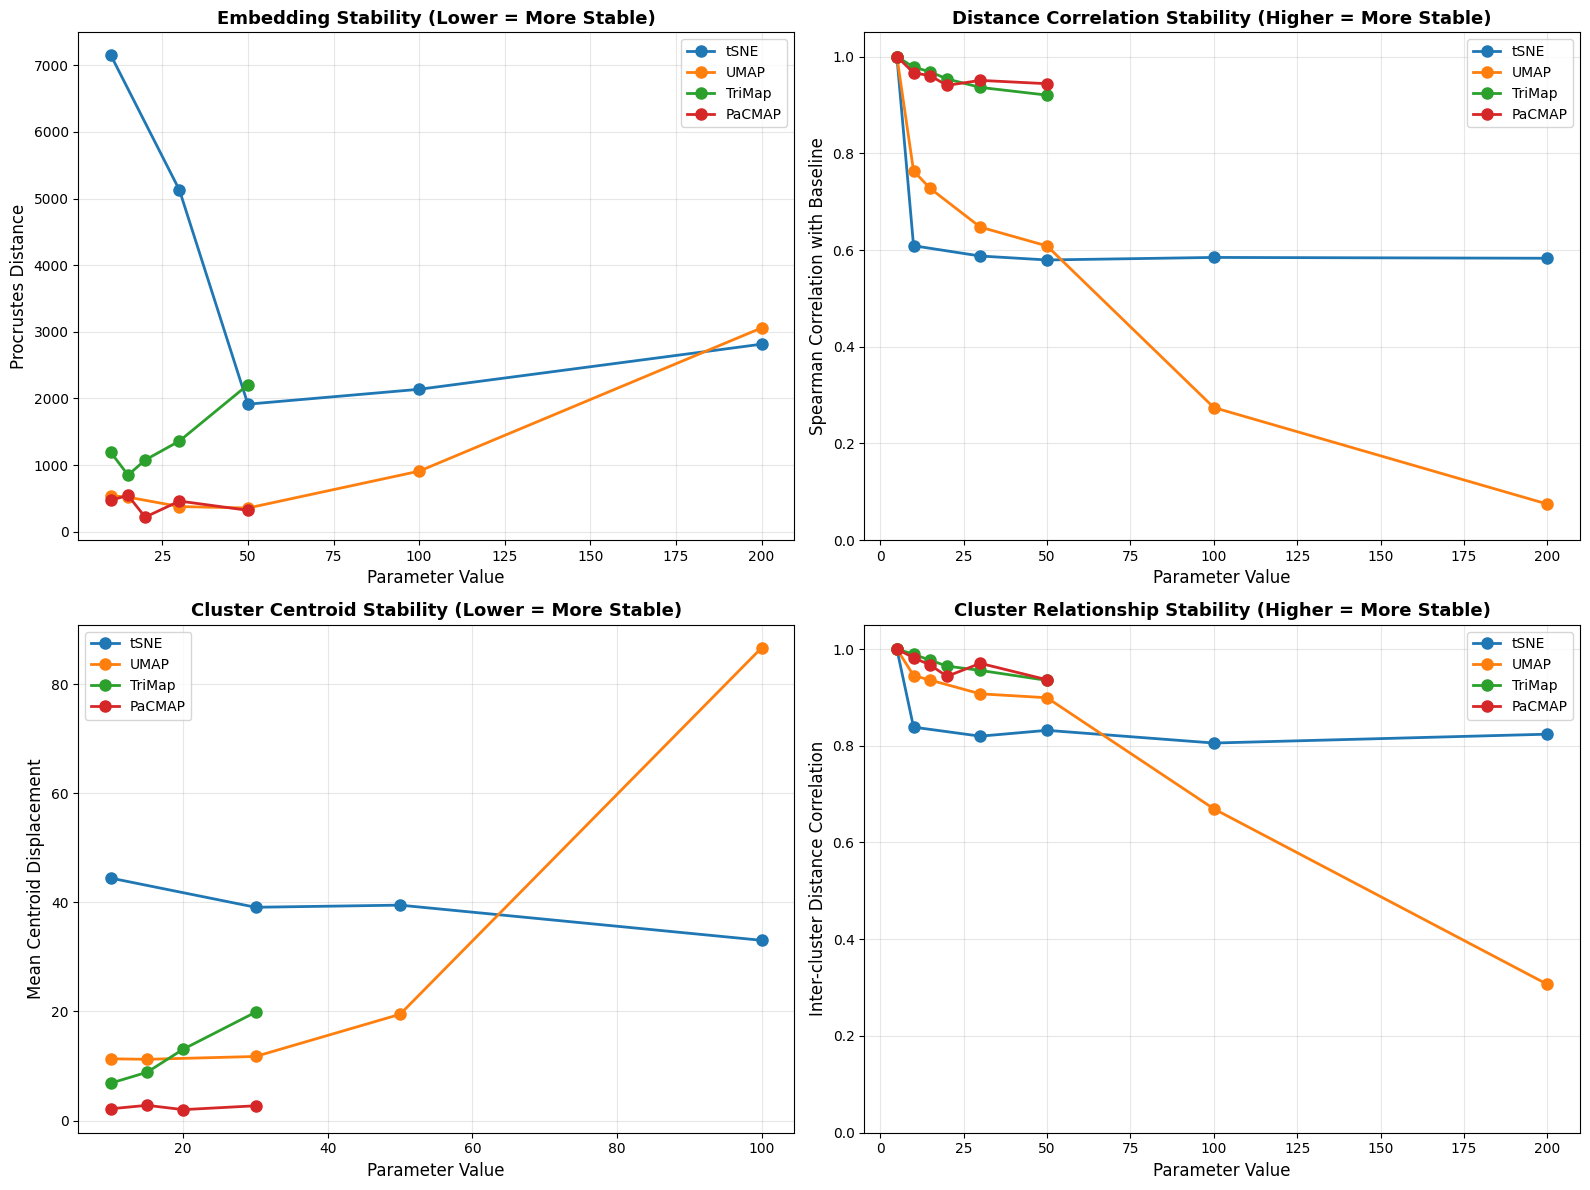

In [37]:
# Create comprehensive visualization
n_methods = len(stability_results)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Procrustes Distance (lower = more stable)
ax = axes[0, 0]
for method_name, metrics in stability_results.items():
    param_values = metrics['param_values'][1:]  # Skip first
    proc_dist = metrics['procrustes_distances']
    ax.plot(param_values, proc_dist, marker='o', label=method_name, linewidth=2, markersize=8)

ax.set_xlabel('Parameter Value', fontsize=12)
ax.set_ylabel('Procrustes Distance', fontsize=12)
ax.set_title('Embedding Stability (Lower = More Stable)', fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Plot 2: Correlation with Baseline (higher = more stable)
ax = axes[0, 1]
for method_name, metrics in stability_results.items():
    param_values = metrics['param_values']
    corr = metrics['correlation_with_baseline']
    ax.plot(param_values, corr, marker='o', label=method_name, linewidth=2, markersize=8)

ax.set_xlabel('Parameter Value', fontsize=12)
ax.set_ylabel('Spearman Correlation with Baseline', fontsize=12)
ax.set_title('Distance Correlation Stability (Higher = More Stable)', fontsize=13, fontweight='bold')
ax.set_ylim([0, 1.05])
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Plot 3: Cluster Centroid Variation (lower = more stable)
ax = axes[1, 0]
for method_name, metrics in stability_results.items():
    param_values = metrics['param_values'][1:len(metrics['centroid_variations'])+1]
    centroid_var = metrics['centroid_variations']
    ax.plot(param_values, centroid_var, marker='o', label=method_name, linewidth=2, markersize=8)

ax.set_xlabel('Parameter Value', fontsize=12)
ax.set_ylabel('Mean Centroid Displacement', fontsize=12)
ax.set_title('Cluster Centroid Stability (Lower = More Stable)', fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Plot 4: Inter-cluster Distance Correlation (higher = more stable)
ax = axes[1, 1]
for method_name, metrics in cluster_stability.items():
    param_values = metrics['param_values']
    corr = metrics['correlations']
    ax.plot(param_values, corr, marker='o', label=method_name, linewidth=2, markersize=8)

ax.set_xlabel('Parameter Value', fontsize=12)
ax.set_ylabel('Inter-cluster Distance Correlation', fontsize=12)
ax.set_title('Cluster Relationship Stability (Higher = More Stable)', fontsize=13, fontweight='bold')
ax.set_ylim([0, 1.05])
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('parameter_sensitivity_analysis.png', dpi=300, bbox_inches='tight')
print("\nSaved: parameter_sensitivity_analysis.png")
plt.show()


In [38]:
# Compute overall stability scores
summary_data = []

for method_name in stability_results.keys():
    metrics = stability_results[method_name]
    cluster_metrics = cluster_stability[method_name]
    
    # Average metrics across parameter values
    avg_procrustes = np.mean(metrics['procrustes_distances'])
    std_procrustes = np.std(metrics['procrustes_distances'])
    
    avg_correlation = np.mean(metrics['correlation_with_baseline'])
    std_correlation = np.std(metrics['correlation_with_baseline'])
    
    avg_cluster_corr = np.mean(cluster_metrics['correlations'])
    min_cluster_corr = np.min(cluster_metrics['correlations'])
    
    summary_data.append({
        'Method': method_name,
        'Avg Procrustes Dist': avg_procrustes,
        'Std Procrustes Dist': std_procrustes,
        'Avg Baseline Corr': avg_correlation,
        'Std Baseline Corr': std_correlation,
        'Avg Cluster Corr': avg_cluster_corr,
        'Min Cluster Corr': min_cluster_corr,
        'Stability Score': avg_correlation * avg_cluster_corr  # Combined score
    })

summary_df = pd.DataFrame(summary_data).set_index('Method')

print("\n" + "="*80)
print("SUMMARY: Parameter Sensitivity (Stability Scores)")
print("="*80)
print(summary_df.round(4))
print("\nInterpretation:")
print("  - Higher Baseline Correlation = More stable across parameters")
print("  - Lower Procrustes Distance = Less variation between parameter settings")
print("  - Higher Cluster Correlation = Cluster relationships preserved")
print("  - Higher Stability Score = Overall more robust method")

# Save results
summary_df.to_csv('parameter_sensitivity_summary.csv')
print("\nResults saved to 'parameter_sensitivity_summary.csv'")

# Rank methods by stability
summary_df_sorted = summary_df.sort_values('Stability Score', ascending=False)
print("\n" + "="*80)
print("Method Ranking by Stability (Most to Least Stable):")
print("="*80)
for idx, (method, row) in enumerate(summary_df_sorted.iterrows(), 1):
    print(f"{idx}. {method:12s} - Stability Score: {row['Stability Score']:.4f}")



SUMMARY: Parameter Sensitivity (Stability Scores)
        Avg Procrustes Dist  Std Procrustes Dist  Avg Baseline Corr  \
Method                                                                
tSNE            3827.873535          2012.861572             0.6572   
UMAP             959.676514           955.658325             0.5850   
TriMap          1335.917969           465.021606             0.9594   
PaCMAP           403.316101           117.261803             0.9602   

        Std Baseline Corr  Avg Cluster Corr  Min Cluster Corr  Stability Score  
Method                                                                          
tSNE               0.1536            0.8533            0.8056           0.5608  
UMAP               0.2893            0.8091            0.3067           0.4734  
TriMap             0.0264            0.9703            0.9352           0.9309  
PaCMAP             0.0199            0.9666            0.9365           0.9281  

Interpretation:
  - Higher Baseline

## Evaluation 5: Computational Efficiency

In [39]:
import numpy as np
import time
import psutil
import os
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap
import trimap
import pacmap
import pandas as pd
import matplotlib.pyplot as plt

def get_memory_usage():
    """Get current memory usage in MB"""
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / 1024 / 1024  # Convert to MB

def evaluate_computational_efficiency(X, method_name, **kwargs):
    """
    Evaluate computational efficiency of a DR method.
    
    Returns:
    --------
    results : dict
        Dictionary containing runtime, peak memory, and embedding
    """
    print(f"\n{'='*60}")
    print(f"Evaluating: {method_name}")
    print('='*60)
    
    # Force garbage collection before measurement
    import gc
    gc.collect()
    
    # Record initial memory
    mem_before = get_memory_usage()
    print(f"Memory before: {mem_before:.2f} MB")
    
    # Start timer
    start_time = time.time()
    
    # Run the method
    try:
        if method_name == 'PCA':
            model = PCA(n_components=2, random_state=42)
            embedding = model.fit_transform(X)
            
        elif method_name == 'tSNE':
            model = TSNE(
                n_components=2, 
                random_state=42, 
                perplexity=kwargs.get('perplexity', 30),
                max_iter=kwargs.get('max_iter', 1000)
            )
            embedding = model.fit_transform(X)
            
        elif method_name == 'UMAP':
            model = umap.UMAP(
                n_components=2, 
                random_state=42, 
                n_neighbors=kwargs.get('n_neighbors', 15),
                min_dist=kwargs.get('min_dist', 0.1)
            )
            embedding = model.fit_transform(X)
            
        elif method_name == 'TriMap':
            model = trimap.TRIMAP(
                n_dims=2,
                n_inliers=kwargs.get('n_inliers', 10),
                n_outliers=kwargs.get('n_outliers', 5),
                n_random=kwargs.get('n_random', 3)
            )
            embedding = model.fit_transform(X)
            
        elif method_name == 'PaCMAP':
            model = pacmap.PaCMAP(
                n_components=2,
                n_neighbors=kwargs.get('n_neighbors', 10),
                MN_ratio=kwargs.get('MN_ratio', 0.5),
                FP_ratio=kwargs.get('FP_ratio', 2.0)
            )
            embedding = model.fit_transform(X, init="pca")
        
        else:
            raise ValueError(f"Unknown method: {method_name}")
        
        # End timer
        elapsed_time = time.time() - start_time
        
        # Record peak memory
        mem_after = get_memory_usage()
        mem_used = mem_after - mem_before
        
        print(f"✓ Completed successfully")
        print(f"  Runtime: {elapsed_time:.2f} seconds ({elapsed_time/60:.2f} minutes)")
        print(f"  Memory after: {mem_after:.2f} MB")
        print(f"  Memory used: {mem_used:.2f} MB")
        
        return {
            'method': method_name,
            'runtime_seconds': elapsed_time,
            'runtime_minutes': elapsed_time / 60,
            'memory_before_mb': mem_before,
            'memory_after_mb': mem_after,
            'memory_used_mb': mem_used,
            'embedding': embedding,
            'success': True
        }
        
    except Exception as e:
        elapsed_time = time.time() - start_time
        print(f"✗ Failed: {e}")
        print(f"  Time before failure: {elapsed_time:.2f} seconds")
        
        return {
            'method': method_name,
            'runtime_seconds': elapsed_time,
            'runtime_minutes': elapsed_time / 60,
            'memory_before_mb': mem_before,
            'memory_after_mb': np.nan,
            'memory_used_mb': np.nan,
            'embedding': None,
            'success': False,
            'error': str(e)
        }

# Evaluate all methods on full dataset
print("="*80)
print("COMPUTATIONAL EFFICIENCY EVALUATION")
print(f"Dataset size: {X_scaled.shape}")
print("="*80)

methods_to_test = ['PCA', 'tSNE', 'UMAP', 'TriMap', 'PaCMAP']

efficiency_results = []

for method_name in methods_to_test:
    result = evaluate_computational_efficiency(X_scaled, method_name)
    efficiency_results.append(result)
    
    # Small delay between methods to allow memory to settle
    time.sleep(2)

# Create results DataFrame
efficiency_df = pd.DataFrame(efficiency_results)
efficiency_df = efficiency_df[efficiency_df['success'] == True]  # Keep only successful runs

print("\n" + "="*80)
print("SUMMARY: Computational Efficiency")
print("="*80)
print(efficiency_df[['method', 'runtime_seconds', 'runtime_minutes', 'memory_used_mb']].to_string(index=False))


COMPUTATIONAL EFFICIENCY EVALUATION
Dataset size: (20000, 2000)

Evaluating: PCA
Memory before: 421.03 MB
✓ Completed successfully
  Runtime: 0.87 seconds (0.01 minutes)
  Memory after: 479.16 MB
  Memory used: 58.12 MB

Evaluating: tSNE
Memory before: 749.83 MB
✓ Completed successfully
  Runtime: 58.37 seconds (0.97 minutes)
  Memory after: 134.72 MB
  Memory used: -615.11 MB

Evaluating: UMAP
Memory before: 426.56 MB


/Users/rkbehera/PySoton/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


✓ Completed successfully
  Runtime: 23.25 seconds (0.39 minutes)
  Memory after: 350.05 MB
  Memory used: -76.52 MB

Evaluating: TriMap
Memory before: 692.48 MB
✓ Completed successfully
  Runtime: 6.37 seconds (0.11 minutes)
  Memory after: 464.70 MB
  Memory used: -227.78 MB

Evaluating: PaCMAP
Memory before: 783.16 MB
✓ Completed successfully
  Runtime: 4.64 seconds (0.08 minutes)
  Memory after: 747.89 MB
  Memory used: -35.27 MB

SUMMARY: Computational Efficiency
method  runtime_seconds  runtime_minutes  memory_used_mb
   PCA         0.874421         0.014574       58.125000
  tSNE        58.373704         0.972895     -615.109375
  UMAP        23.248812         0.387480      -76.515625
TriMap         6.369471         0.106158     -227.781250
PaCMAP         4.637588         0.077293      -35.265625



Saved: computational_efficiency_analysis.png


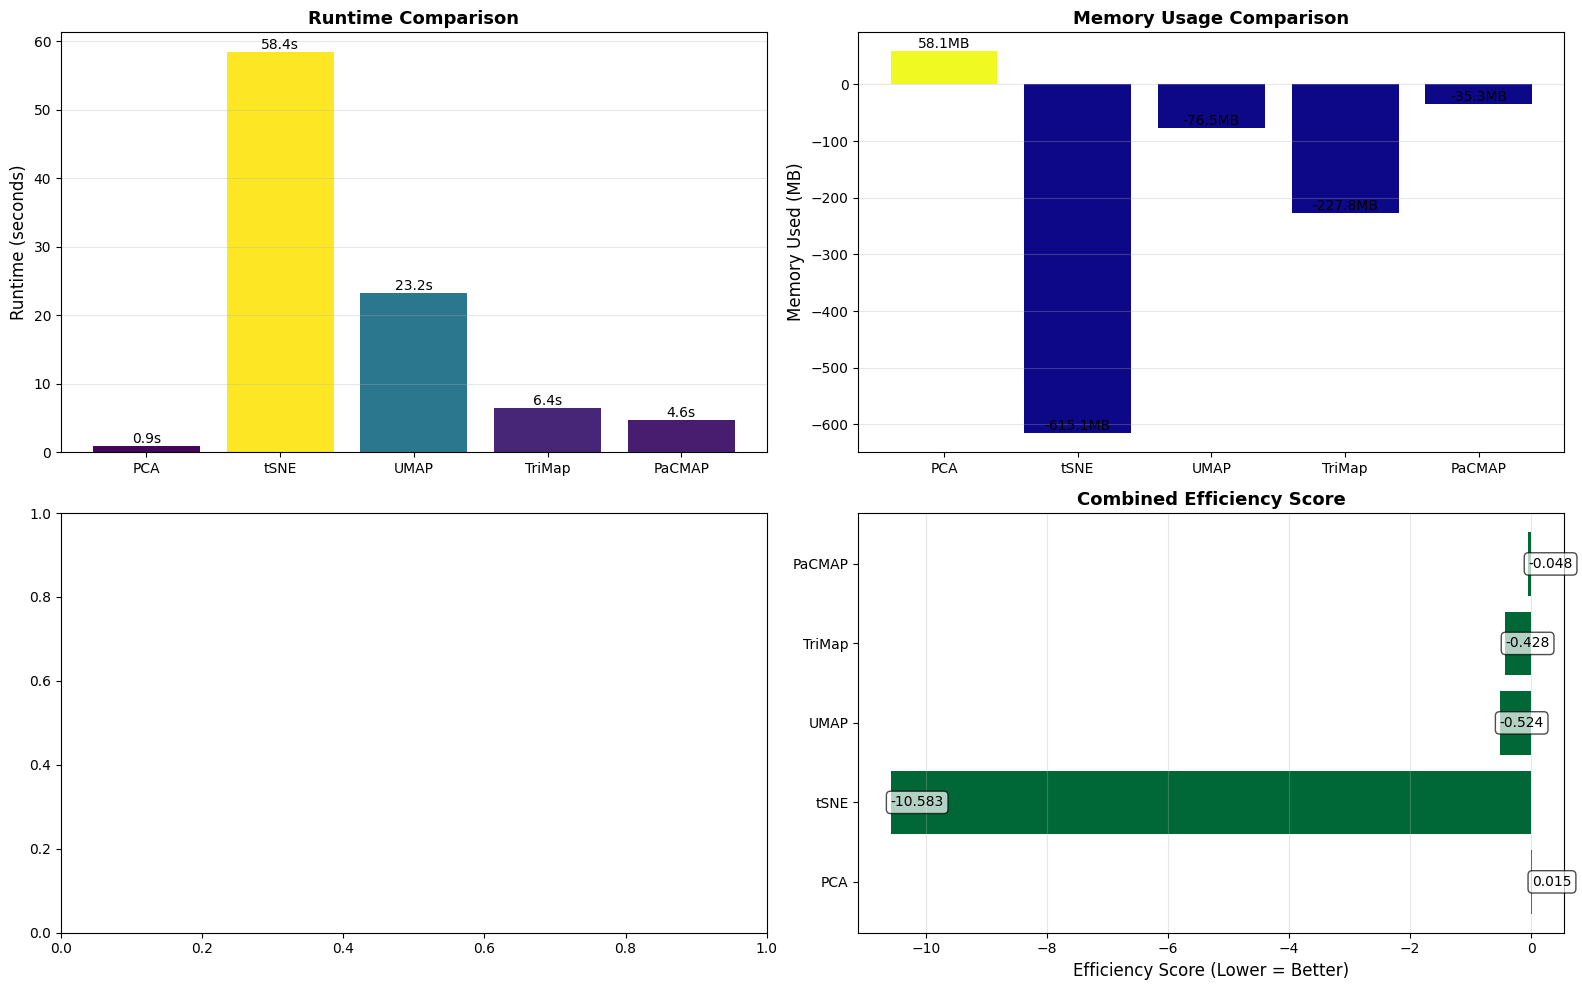

In [41]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Plot 1: Runtime Comparison (Bar Chart)
ax = axes[0, 0]
methods = efficiency_df['method'].values
runtimes = efficiency_df['runtime_seconds'].values

bars = ax.bar(methods, runtimes, color=plt.cm.viridis(runtimes / runtimes.max()))
ax.set_ylabel('Runtime (seconds)', fontsize=12)
ax.set_title('Runtime Comparison', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, val in zip(bars, runtimes):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:.1f}s', ha='center', va='bottom', fontsize=10)

# Plot 2: Memory Usage (Bar Chart)
ax = axes[0, 1]
memory = efficiency_df['memory_used_mb'].values

bars = ax.bar(methods, memory, color=plt.cm.plasma(memory / memory.max()))
ax.set_ylabel('Memory Used (MB)', fontsize=12)
ax.set_title('Memory Usage Comparison', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# Add value labels
for bar, val in zip(bars, memory):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:.1f}MB', ha='center', va='bottom', fontsize=10)

# Plot 3: Runtime vs Sample Size (Scaling)
# ax = axes[1, 0]
# for method_name, results in scaling_results.items():
#     if results:
#         sample_sizes_tested = [r['n_samples'] for r in results if r['success']]
#         runtimes_tested = [r['runtime_seconds'] for r in results if r['success']]
#         ax.plot(sample_sizes_tested, runtimes_tested, marker='o', 
#                 label=method_name, linewidth=2, markersize=8)

# ax.set_xlabel('Number of Samples', fontsize=12)
# ax.set_ylabel('Runtime (seconds)', fontsize=12)
# ax.set_title('Runtime Scaling with Dataset Size', fontsize=13, fontweight='bold')
# ax.legend(fontsize=10)
# ax.grid(True, alpha=0.3)

# Plot 4: Efficiency Score (Runtime * Memory normalized)
ax = axes[1, 1]

# Compute efficiency score (lower is better)
# Normalize both metrics to [0, 1] and combine
runtime_norm = runtimes / runtimes.max()
memory_norm = memory / memory.max()
efficiency_score = runtime_norm * memory_norm

bars = ax.barh(methods, efficiency_score, color=plt.cm.RdYlGn_r(efficiency_score))
ax.set_xlabel('Efficiency Score (Lower = Better)', fontsize=12)
ax.set_title('Combined Efficiency Score', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')

# Add value labels
for bar, val in zip(bars, efficiency_score):
    width = bar.get_width()
    ax.text(width, bar.get_y() + bar.get_height()/2.,
            f'{val:.3f}', ha='left', va='center', fontsize=10, 
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

plt.tight_layout()
plt.savefig('computational_efficiency_analysis.png', dpi=300, bbox_inches='tight')
print("\nSaved: computational_efficiency_analysis.png")
plt.show()


In [43]:
# Generate detailed summary report
print("\n" + "="*80)
print("DETAILED EFFICIENCY REPORT")
print("="*80)

# Sort by runtime
efficiency_df_sorted = efficiency_df.sort_values('runtime_seconds')

print("\nRanking by Runtime (Fastest to Slowest):")
print("-" * 60)
for idx, row in efficiency_df_sorted.iterrows():
    print(f"{row['method']:12s}: {row['runtime_seconds']:7.2f}s ({row['runtime_minutes']:.2f} min) | Memory: {row['memory_used_mb']:.1f} MB")

# Compute relative performance
fastest_time = efficiency_df_sorted['runtime_seconds'].iloc[0]
print(f"\nRelative Performance (compared to fastest method):")
print("-" * 60)
for idx, row in efficiency_df_sorted.iterrows():
    speedup = row['runtime_seconds'] / fastest_time
    print(f"{row['method']:12s}: {speedup:5.2f}x slower")

# Throughput (samples per second)
print(f"\nThroughput (samples/second):")
print("-" * 60)
n_samples = X_scaled.shape[0]
for idx, row in efficiency_df_sorted.iterrows():
    throughput = n_samples / row['runtime_seconds']
    print(f"{row['method']:12s}: {throughput:8.1f} samples/sec")

# Save results
efficiency_df.to_csv('computational_efficiency_results.csv', index=False)
print("\nResults saved to 'computational_efficiency_results.csv'")

# Save scaling results if available
# if scaling_results:
#     scaling_data = []
#     for method, results in scaling_results.items():
#         for result in results:
#             if result['success']:
#                 scaling_data.append({
#                     'method': method,
#                     'n_samples': result['n_samples'],
#                     'runtime_seconds': result['runtime_seconds'],
#                     'memory_used_mb': result['memory_used_mb']
#                 })
    
#     scaling_df = pd.DataFrame(scaling_data)
#     scaling_df.to_csv('scaling_analysis_results.csv', index=False)
#     print("Scaling results saved to 'scaling_analysis_results.csv'")



DETAILED EFFICIENCY REPORT

Ranking by Runtime (Fastest to Slowest):
------------------------------------------------------------
PCA         :    0.87s (0.01 min) | Memory: 58.1 MB
PaCMAP      :    4.64s (0.08 min) | Memory: -35.3 MB
TriMap      :    6.37s (0.11 min) | Memory: -227.8 MB
UMAP        :   23.25s (0.39 min) | Memory: -76.5 MB
tSNE        :   58.37s (0.97 min) | Memory: -615.1 MB

Relative Performance (compared to fastest method):
------------------------------------------------------------
PCA         :  1.00x slower
PaCMAP      :  5.30x slower
TriMap      :  7.28x slower
UMAP        : 26.59x slower
tSNE        : 66.76x slower

Throughput (samples/second):
------------------------------------------------------------
PCA         :  22872.3 samples/sec
PaCMAP      :   4312.6 samples/sec
TriMap      :   3140.0 samples/sec
UMAP        :    860.3 samples/sec
tSNE        :    342.6 samples/sec

Results saved to 'computational_efficiency_results.csv'
